# Tutorial: Using the Vortex-Profile Matching Dataset

## Overview

This dataset integrates the **World Ocean Database (WOD)** with the **Mesoscale Eddy Trajectory Atlas (META3.2 DT)**, offering a comprehensive resource to study ocean mesoscale dynamics. It includes over millions of vertical ocean profiles matched with altimetry-tracked eddies data. This tutorial gives an example of access to the dataset through OPeNDAP server.


## We start by importing the necessary packages

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import gsw
from tqdm import tqdm
from datetime import datetime
import requests
from xhistogram.xarray import histogram

We are showing the versions of the packages, but you should be fine if you used the provided `yaml` file to create your `conda`/`mamba` environment.

In [2]:
print("numpy version:", np.__version__)
print("xarray version:", xr.__version__)
print("matplotlib version:", matplotlib.__version__)
print("gsw version:", gsw.__version__)

numpy version: 1.23.5
xarray version: 2024.3.0
matplotlib version: 3.6.2
gsw version: 3.4.0


## Accessing and combining datasets

We here define the bounds of the region of interest. In this case, is the Kuroshio current.

In [3]:
latmin, latmax = -50, -40
lonmin, lonmax = -40, -30
timemin, timemax = np.datetime64(datetime(2009, 5, 1)), np.datetime64(datetime(2009, 10, 1))

Here we access the dataset and filter profiles within the region of interest. We selected the CTD casts only from 2000 to 2004. It should take a few minutes to load the data. If you need faster access or a larger spatiotemporal domain, you could use `dask` for parallelized access do the server. 

In [4]:
url = "http://bigcreek.whoi.edu:8080/thredds/dodsC/VORTEX_PROFILE/Matched/matched_pfl_Temperature.nc?eddy_track[0:1:-1]"
ds = xr.open_dataset(url).load()
ind = np.argwhere((ds.eddy_track==578618).values).flatten()
casts_min, casts_max = ind.min(), ind.max()
ds

<xarray.Dataset> Size: 2MB
Dimensions:     (casts: 427264)
Dimensions without coordinates: casts
Data variables:
    eddy_track  (casts) float32 2MB 7.515e+05 6.94e+05 ... 9.085e+04 1.018e+05
Attributes: (12/48)
    institution:                         National Centers for Environmental I...
    source:                              World Ocean Database
    references:                          World Ocean Database 2018. URL:http:...
    title:                               World Ocean Database - Multi-cast file
    summary:                             Data for multiple casts from the Wor...
    id:                                  /nodc/data/OCLAB/OCL/retrieval/month...
    ...                                  ...
    project.DODS.strlen:                 80
    project.DODS.dimName:                string80
    ocean_vehicle.DODS.strlen:           79
    ocean_vehicle.DODS.dimName:          string79
    platform.DODS.strlen:                28
    platform.DODS.dimName:               string28

In [5]:
casts_max-casts_min

136922

In [6]:
variables = ["eddy_rotation","eddy_longitude","eddy_latitude","temperature", "eddy_track"]
casts_slice = f"[{casts_min}:1:{casts_max}]"
url = f"http://bigcreek.whoi.edu:8080/thredds/dodsC/VORTEX_PROFILE/Matched/matched_pfl_Temperature.nc?levels[0:1:100],casts{casts_slice},temperature{casts_slice}[0:1:100],z{casts_slice}[0:1:100],lat{casts_slice},lon{casts_slice},time{casts_slice},eddy_speed_radius{casts_slice},eddy_track{casts_slice},eddy_latitude{casts_slice},eddy_longitude{casts_slice},eddy_rotation{casts_slice},eddy_umax{casts_slice}"
ds = xr.open_dataset(url)
ind = np.argwhere((ds.eddy_track==578618).values).flatten()
ds = ds.isel(casts=ind)[variables].load()
ds

<xarray.Dataset> Size: 898kB
Dimensions:         (casts: 1063, levels: 101)
Coordinates:
  * levels          (levels) float32 404B 0.0 1.0 2.0 3.0 ... 98.0 99.0 100.0
  * casts           (casts) int32 4kB 15997996 15999299 ... 16641556 15855554
    lat             (casts) float32 4kB 30.12 29.17 30.43 ... 27.07 30.37 31.22
    lon             (casts) float32 4kB 145.9 147.4 146.5 ... 138.9 147.7 151.9
    time            (casts) datetime64[ns] 9kB 2014-04-03T10:49:41.250000 ......
    z               (casts, levels) float32 429kB 5.065 10.53 ... 1.484e+03
Data variables:
    eddy_rotation   (casts) float32 4kB -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    eddy_longitude  (casts) float32 4kB 146.8 146.6 146.2 ... 139.4 146.3 152.7
    eddy_latitude   (casts) float32 4kB 29.59 29.59 29.64 ... 27.31 29.63 30.82
    temperature     (casts, levels) float32 429kB 18.84 18.84 ... 2.696 2.649
    eddy_track      (casts) float32 4kB 5.786e+05 5.786e+05 ... 5.786e+05
Attributes: (12/48)
    institution:                         National Centers for Environmental I...
    source:                              World Ocean Database
    references:                          World Ocean Database 2018. URL:http:...
    title:                               World Ocean Database - Multi-cast file
    summary:                             Data for multiple casts from the Wor...
    id:                                  /nodc/data/OCLAB/OCL/retrieval/month...
    ...                                  ...
    project.DODS.strlen:                 80
    project.DODS.dimName:                string80
    ocean_vehicle.DODS.strlen:           79
    ocean_vehicle.DODS.dimName:          string79
    platform.DODS.strlen:                28
    platform.DODS.dimName:               string28

In [18]:
url = "http://bigcreek.whoi.edu:8080/thredds/dodsC/VORTEX_PROFILE/Matched/matched_pfl_Temperature.nc?levels[0:1:100],casts[0:1:-1],temperature[0:1:-1][0:1:100],z[0:1:-1][0:1:100],lat[0:1:-1],lon[0:1:-1],time[0:1:-1],eddy_speed_radius[0:1:-1],eddy_track[0:1:-1],eddy_latitude[0:1:-1],eddy_longitude[0:1:-1],eddy_rotation[0:1:-1],eddy_umax[0:1:-1]"
ds = xr.open_dataset(url)
# ds.eddy_track.load()
ds

OSError: [Errno -77] NetCDF: Access failure: 'http://bigcreek.whoi.edu:8080/thredds/dodsC/VORTEX_PROFILE/Matched/matched_pfl_Temperature.nc?levels[0:1:100],casts[0:1:-1],temperature[0:1:-1][0:1:100],z[0:1:-1][0:1:100],lat[0:1:-1],lon[0:1:-1],time[0:1:-1],eddy_speed_radius[0:1:-1],eddy_track[0:1:-1],eddy_latitude[0:1:-1],eddy_longitude[0:1:-1],eddy_rotation[0:1:-1],eddy_umax[0:1:-1]'

In [14]:
variables = ["eddy_rotation","eddy_longitude","eddy_latitude","temperature", "eddy_track"]

# url = "http://bigcreek.whoi.edu:8080/thredds/dodsC/VORTEX_PROFILE/Matched/matched_pfl_Temperature.nc"
url = "http://bigcreek.whoi.edu:8080/thredds/dodsC/VORTEX_PROFILE/Matched/matched_pfl_Temperature.nc?levels[0:1:100],casts[0:1:0],temperature[0:1:0][0:1:100],z[0:1:0][0:1:100],lat[0:1:0],lon[0:1:0],time[0:1:0],eddy_speed_radius[0:1:0],eddy_track[0:1:0],eddy_latitude[0:1:0],eddy_longitude[0:1:0],eddy_rotation[0:1:0],eddy_umax[0:1:0]"
ds = xr.open_dataset(url)
ds.eddy_track.load()

ind = np.argwhere((ds.eddy_track==578618).values).flatten()
ds = ds.isel(casts=ind, levels=slice(0,100))[variables].load()
ds

<xarray.Dataset> Size: 400B
Dimensions:         (casts: 0, levels: 100)
Coordinates:
  * levels          (levels) float32 400B 0.0 1.0 2.0 3.0 ... 97.0 98.0 99.0
  * casts           (casts) int32 0B 
    lat             (casts) float32 0B 
    lon             (casts) float32 0B 
    time            (casts) datetime64[ns] 0B 
    z               (casts, levels) float32 0B 
Data variables:
    eddy_rotation   (casts) float32 0B 
    eddy_longitude  (casts) float32 0B 
    eddy_latitude   (casts) float32 0B 
    temperature     (casts, levels) float32 0B 
    eddy_track      (casts) float32 0B 
Attributes: (12/48)
    institution:                         National Centers for Environmental I...
    source:                              World Ocean Database
    references:                          World Ocean Database 2018. URL:http:...
    title:                               World Ocean Database - Multi-cast file
    summary:                             Data for multiple casts from the Wor...
    id:                                  /nodc/data/OCLAB/OCL/retrieval/month...
    ...                                  ...
    project.DODS.strlen:                 80
    project.DODS.dimName:                string80
    ocean_vehicle.DODS.strlen:           79
    ocean_vehicle.DODS.dimName:          string79
    platform.DODS.strlen:                28
    platform.DODS.dimName:               string28

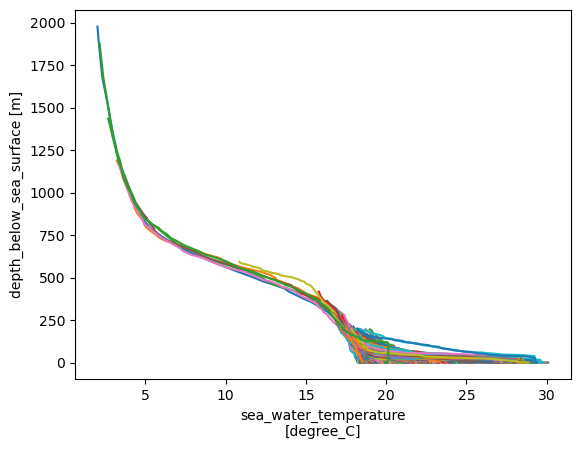

In [11]:
ds.temperature.plot.line(y="z", hue="casts", add_legend=False);

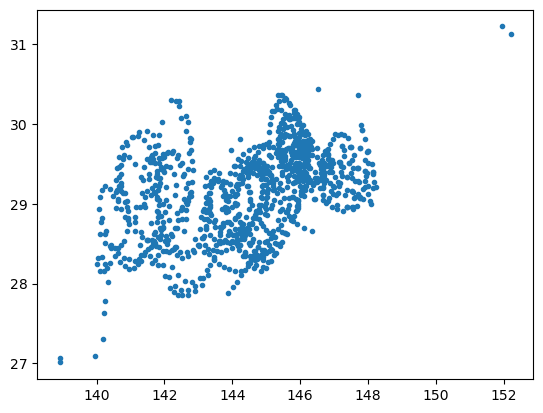

In [21]:
dsi = ds.where(ds.eddy_track==578618, drop=True)

plt.plot(dsi.lon, dsi.lat, ".")

In [ ]:
565341

In [11]:
# list the 10 eddy_track ID that has more repeated elements
unique, counts = np.unique(ds.eddy_track.values, return_counts=True)
top10_idx = np.argsort(counts)[::-1][:10]
for i in top10_idx:
	print(f"eddy_track ID: {unique[i]:.0f}, count: {counts[i]}")

eddy_track ID: 565341, count: 1557
eddy_track ID: 527467, count: 1515
eddy_track ID: 578618, count: 1063
eddy_track ID: 559928, count: 682
eddy_track ID: 534841, count: 557
eddy_track ID: 766830, count: 374
eddy_track ID: 545181, count: 358
eddy_track ID: 677907, count: 306
eddy_track ID: 725026, count: 303
eddy_track ID: 701374, count: 272


In [130]:
base_url = {
    "UMassD": "http://www.smast.umassd.edu:8081/thredds/fileServer/Vortex_profiles/vortex_profiles",
    "WHOI": "http://bigcreek.whoi.edu:8080/thredds/fileServer/VORTEX_PROFILE"
}

geturl = lambda server,dataset,variable: f"{base_url[server]}/Matched/matched_{dataset.lower()}_{variable.title()}.nc"

In [ ]:
server = "WHOI"
dataset = "pfl"
variables = ["temperature", "salinity"]

for variable in variables:
    output_file = f"../data/external/matched_{dataset.lower()}_{variable.title()}.nc"

    response = requests.get(geturl(server,dataset,variable), stream=True)
    response.raise_for_status()  # raise error if download failed

    with open(output_file, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)

In [6]:
temp = xr.open_dataset(f"../data/external/matched_{dataset.lower()}_Temperature.nc").load()
salt = xr.open_dataset(f"../data/external/matched_{dataset.lower()}_Salinity.nc").load()

We now combine the temperature and salinity profiles based on common cast ids.

In [7]:
ds = xr.merge([temp, salt])
ds

<xarray.Dataset> Size: 1GB
Dimensions:                             (levels: 454, casts: 167486,
                                         NbSample: 20)
Coordinates:
  * levels                              (levels) float32 2kB 0.0 1.0 ... 453.0
  * casts                               (casts) int32 670kB 7969532 ... 21324907
    z                                   (casts, levels) float32 304MB 0.0 ......
    lat                                 (casts) float32 670kB 41.33 ... -43.89
    lon                                 (casts) float32 670kB -125.3 ... -58.2
    time                                (casts) datetime64[ns] 1MB 1997-03-23...
Dimensions without coordinates: NbSample
Data variables: (12/37)
    temperature                         (casts, levels) float32 304MB 11.2 .....
    platform                            (casts) object 1MB b'' ... b'AUTONOMO...
    project                             (casts) object 1MB b'AUTONOMOUS PINNI...
    ocean_vehicle                       (casts) object 1MB b'' ... b'Elephant...
    wod_cruise_identifier               (casts) object 1MB b'US025541' ... b'...
    eddy_effective_contour_latitude     (casts, NbSample) float32 13MB 41.88 ...
    ...                                  ...
    eddy_inner_contour_height           (casts) float32 670kB 0.092 ... -0.314
    eddy_speed_area                     (casts) float32 670kB 1.647e+10 ... 6...
    eddy_effective_radius               (casts) float32 670kB 7.51e+04 ... 6....
    eddy_f                              (casts) float32 670kB 9.655e-05 ... 0...
    eddy_num_contours                   (casts) float32 670kB 27.0 27.0 ... 26.0
    salinity                            (casts, levels) float32 304MB nan ......
Attributes: (12/38)
    institution:                   National Centers for Environmental Informa...
    source:                        World Ocean Database
    references:                    World Ocean Database 2018. URL:http://data...
    title:                         World Ocean Database - Multi-cast file
    summary:                       Data for multiple casts from the World Oce...
    id:                            /nodc/data/oc5.clim.4/wod_update_nc/2008/w...
    ...                            ...
    history:                       
    license:                       
    standard_name_vocabulary:      CF Standard Name Table v41
    featureType:                   Profile
    cdm_data_type:                 Profile
    Conventions:                   CF-1.6

In [15]:
where = (
    (ds.lon>lonmin) & (ds.lon<lonmax) &
    (ds.lat>latmin) & (ds.lat<latmax) &
    (ds.time>timemin) & (ds.time<timemax)
)

ind = np.argwhere(where.values).flatten()

ds = ds.isel(casts=ind)

In [50]:
dsi = ds.where(ds.eddy_track == 469349, drop=True)
dsi = dsi.where(~np.isnan(dsi.temperature).all("casts"), drop=True)

In [ ]:
p = gsw.p_from_z(-dsi.z, lat=dsi.lat)
dsi["absolute_salinity"] = gsw.SA_from_SP(dsi.salinity, dsi.z, dsi.lon, dsi.lat)
dsi["conservative_temperature"] = gsw.CT_from_t(dsi.absolute_salinity, dsi.temperature, p)


In [77]:
base_url = "https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa"
params = ["temperature", "salinity"]

datasets = []
months = np.arange(1, 13)

for param in tqdm(params):
    urls = [f"{base_url}/{param}/decav/1.00/woa18_decav_{param[0]}{m:02.0f}_01.nc" for m in months]
    woa = xr.open_mfdataset(urls, decode_times=False, parallel=True)

    woa = woa.rename(time="month").assign_coords(month=months)  
    datasets.append(woa)

woa = xr.merge(datasets)#.load()
woa = woa.rename(depth="z")
woa = woa.sel(lon=slice(lonmin,lonmax), lat=slice(latmin,latmax))[["s_an", "t_an"]].load()


p = gsw.p_from_z(-woa.z, lat=woa.lat)
woa["clim_absolute_salinity"] = gsw.SA_from_SP(woa.s_an, woa.z, woa.lon, woa.lat)
woa["clim_conservative_temperature"] = gsw.CT_from_t(woa.clim_absolute_salinity, woa.t_an, p)

100%|██████████| 2/2 [00:46<00:00, 23.34s/it]


In [78]:
clim = woa.interp(lon=dsi.lon, lat=dsi.lat, month=dsi.time.dt.month, z=dsi.z)
dsi["anom_absolute_salinity"] = dsi.absolute_salinity-clim.clim_absolute_salinity
dsi["anom_conservative_temperature"] = dsi.conservative_temperature-clim.clim_conservative_temperature

In [93]:
cast_longitude = dsi.lon.values
cast_latitude = dsi.lat.values
eddy_longitude = dsi.isel(levels=0).eddy_longitude.values
eddy_latitude = dsi.isel(levels=0).eddy_latitude.values
radius = dsi.isel(levels=0).eddy_speed_radius.values

In [102]:
longitude = np.vstack([cast_longitude, eddy_longitude])
latitude = np.vstack([cast_latitude, eddy_latitude])
distance = gsw.distance(longitude, latitude, axis=0).flatten()/radius
dsi["distance"] = (("casts"), distance)

In [127]:
bins = [[0,50,150,250,350,450,550], np.arange(0,1.5,0.1)]
H = histogram(dsi.z, dsi.distance, bins=bins)
temperature = histogram(dsi.z, dsi.distance, bins=bins, weights=dsi.anom_conservative_temperature.fillna(0))/H
salinity = histogram(dsi.z, dsi.distance, bins=bins, weights=dsi.anom_absolute_salinity.fillna(0))/H

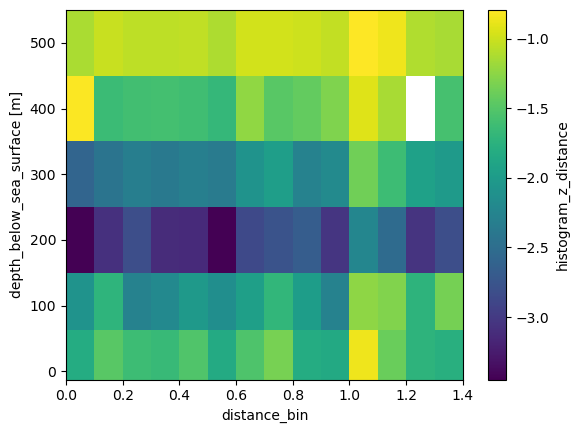

In [129]:
temperature.plot()

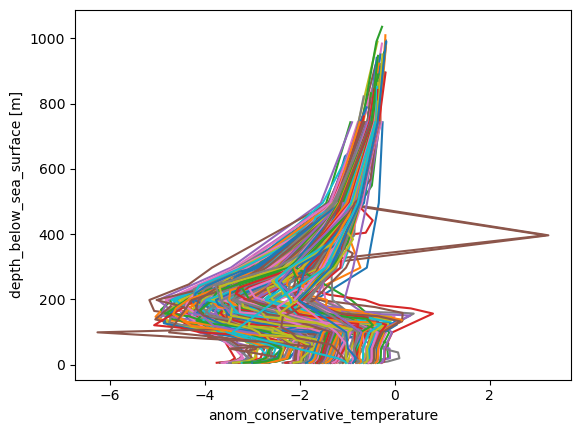

In [79]:
dsi.anom_conservative_temperature.plot.line(y="z", add_legend=False, hue="casts");

In [68]:
longitude = np.vstack([dsi.lon.values, dsi.eddy_longitude.values])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 251 and the array at index 1 has size 17

In [ ]:
bins = [np.arange()]
histogram()

To compute anomalies, we need to load data from the World Ocean Atlas and estimate TEOS-10 variables from it.

Then we can estimate the salinity and temperature anomalies within eddies by computing the difference to the climatology interpolated to the location and month of the profiles.

Once we estimate the anomalies, we coul make a plot for all profiles.

In [ ]:
%%time
variables = {
    "anom_conservative_temperature": {
        "label": "Temperature anomaly [$^\circ$C]",
        "xlim": [-12, 12],
    },
    "anom_absolute_salinity": {
        "label": "Salinity anom. [g/kg]",
        "xlim": [-1.3, 1.3],
    },
}

fig, ax = plt.subplots(1,2, figsize=(10,4))

for a, var in zip(ax, variables):
    a.scatter(ds[var][ds.eddy_Ro>0].T, ds.z[ds.eddy_Ro>0].T, s=0.4, c="blue", alpha=0.02);
    a.scatter(ds[var][ds.eddy_Ro<0].T, ds.z[ds.eddy_Ro<0].T, s=0.4, c="red", alpha=0.02);
    
    a.grid(True, linestyle="--", alpha=0.5)
    a.set(ylim=[1000,0], xlabel=variables[var]["label"], xlim=variables[var]["xlim"], ylabel="z [m]")
    a.axvline(0, linestyle="--", color="0.2", zorder=1e3)

# Create custom legend handles
custom_legend = [
    Line2D([0], [0], color="blue", lw=1, label="cyclones", alpha=0.5),
    Line2D([0], [0], color="red", lw=1, label="anticyclones", alpha=0.5),
]

# Add the legend to the first axis
ax[0].legend(handles=custom_legend, loc="lower left")

fig.savefig("../img/anomalies.png", bbox_inches="tight", facecolor="w", dpi=300)

The figure illustrates the vertical profiles of temperature and salinity anomalies for cyclonic (blue) and anticyclonic (red) eddies, extending to 1000 meters. 

Cyclones, characterized by low-pressure systems, typically exhibit negative temperature anomalies near the surface due to the upward displacement of isopycnals (cold cores). These anomalies diminish with increasing depth as the mixing effect of cyclones weakens.

On the other hand, anticyclones, associated with high-pressure systems, show positive temperature anomalies near the surface caused by the downward displacement of isopycnal (warm cores). Similar to cyclones, these anomalies gradually weaken with depth. Notably, beyond 600-800 meters, the influence of both cyclones and anticyclones on the water column diminishes, and the anomalies converge around zero.

The salinity anomalies are more complex since they depend on the distribution of water masses in the region.

This plot effectively captures the contrasting thermal structures of cyclones and anticyclones, highlighting their impact on ocean stratification, heat transport, and mixing processes. Additionally, the visualization serves as a validation of the dataset by demonstrating consistency with theoretical expectations of mesoscale eddy behavior..
